# Comprehensive NASA Breakup Model Analysis
## Parametric Study: Impact of Different Collision Parameters

This notebook analyzes simulation results across **FOUR distinct parameter variations**:

### 1. **Minimum Characteristic Length** (13 scenarios)
- **0.001 m (1 mm)**: Ultra-fine particles
- **0.003 m (3 mm)**: Very fine dust
- **0.005 m (5 mm)**: Fine debris
- **0.01 m**: Extremely small fragments - high sensitivity
- **0.02 m (2 cm)**: Fine detail tracking
- **0.03 m (3 cm)**: Fine tracking
- **0.05 m**: BASELINE - standard tracking threshold  
- **0.1 m**: Medium debris only
- **0.2 m**: Large debris only
- **0.5 m (50 cm)**: Major pieces - coarse tracking
- **1.0 m**: Very large collision remnants
- **2.0 m**: Extreme (building-sized)
- **5.0 m**: Maximum tracking (collision cores only)
- **Effect**: Dramatically increases/decreases total fragment count (power law: ~10-100x scaling)
- **Physics**: Detection/tracking capability limitations across resolution spectrum

### 2. **Relative Velocity** (3 scenarios)
- **Zero velocity**: Both satellites identical velocity (NO collision, baseline reference)
- **Head-on collision (15 km/s)**: Opposite directions (v1=[0, 7500, 0], v2=[0, -7500, 0])
- **High velocity (15 km/s)**: Same as head-on (maximum destructive energy)
- **Effect**: Kinetic energy dramatically changes fragmentation
- **Physics**: Energy = ½ × μ × v_rel² determines breakup severity

### 3. **Satellite Mass** (3 scenarios)
- **Low**: 300 kg + 500 kg (symmetric reduction)
- **High**: 800 kg + 1200 kg (symmetric increase)
- **Extreme**: 1200 kg + 1500 kg (both very massive, maximum total energy)
- **Effect**: Total impact energy affects fragment count
- **Physics**: Larger masses generate more debris (momentum-energy scaling)

### 4. **Satellite Radius** (3 scenarios)
- **Small**: 0.5-0.6 m (compact geometry, -50% area)
- **Large**: 2.5-3.0 m (extended geometry, +150-173% area)
- **Extreme**: 4.0-5.0 m (both very large, maximum cross-sectional area)
- **Effect**: Impact area determines energy density and fragmentation pattern
- **Physics**: Larger cross-section = higher energy density = more fragments

**All scenarios** use explicit velocity and position vectors for controllable collision parameters


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy import stats
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")
plt.rcParams["figure.dpi"] = 100
plt.rcParams['figure.figsize'] = (14, 8)

# Create output directory for figures
figures_dir = Path("./analysis_figures")
figures_dir.mkdir(exist_ok=True)

print("Setup complete. Ready for data analysis.")

Setup complete. Ready for data analysis.


## Helper Functions

In [2]:
def load_and_process_result(filename):
    """
    Load a result CSV file and process it with calculated metrics
    """
    if not os.path.exists(filename):
        print(f"Warning: {filename} not found")
        return None
    
    df = pd.read_csv(filename)
    
    # Parse vector columns
    def parse_vector_column(column):
        try:
            return column.apply(
                lambda x: np.fromstring(
                    x.strip("[]"),
                    sep=" "
                )
            )
        except:
            return None
    
    # Parse vectors
    if "Velocity [m/s]" in df.columns:
        df["Velocity_vec"] = parse_vector_column(df["Velocity [m/s]"])
        df["Vx"] = df["Velocity_vec"].apply(lambda x: x[0] if x is not None else np.nan)
        df["Vy"] = df["Velocity_vec"].apply(lambda x: x[1] if x is not None else np.nan)
        df["Vz"] = df["Velocity_vec"].apply(lambda x: x[2] if x is not None else np.nan)
        df["Velocity_norm"] = df["Velocity_vec"].apply(lambda x: np.linalg.norm(x) if x is not None else np.nan)
    
    if "Ejection Velocity [m/s]" in df.columns:
        df["Ejection_vec"] = parse_vector_column(df["Ejection Velocity [m/s]"])
        df["Ejection_norm"] = df["Ejection_vec"].apply(lambda x: np.linalg.norm(x) if x is not None else np.nan)
    
    if "Position [m]" in df.columns:
        df["Position_vec"] = parse_vector_column(df["Position [m]"])
    
    # Calculated metrics
    if "Mass [kg]" in df.columns and "Area [m^2]" in df.columns:
        df["Mass_to_Area"] = df["Mass [kg]"] / df["Area [m^2]"]
        df["Log_Mass"] = np.log10(df["Mass [kg]"])
    
    return df

def save_figure(fig, name):
    """Save figure to analysis_figures directory"""
    fig.savefig(figures_dir / f"{name}.png", dpi=100, bbox_inches='tight')
    print(f"Saved: {name}.png")

print("Helper functions defined.")

Helper functions defined.


## 1. Analysis: Minimum Characteristic Length Variations

In [3]:
# Load all minimum characteristic length variations (13 scenarios)
# These use TLE-based orbital mechanics (natural 7.6 km/s collision)
# Parameter: minimalCharacteristicLength in config (0.001 m through 5.0 m)
# Expected: Fragment count decreases dramatically as minimum threshold increases

minlen_files = {
    '0.001 m (ultra-fine, 1 mm)': 'analysis_minlen_0.001_result.csv',
    '0.003 m (very fine, 3 mm)': 'analysis_minlen_0.003_result.csv',
    '0.005 m (very fine, 5 mm)': 'analysis_minlen_0.005_result.csv',
    '0.01 m (fine)': 'analysis_minlen_0.01_result.csv',
    '0.02 m (fine, 2 cm)': 'analysis_minlen_0.02_result.csv',
    '0.03 m (fine, 3 cm)': 'analysis_minlen_0.03_result.csv',
    '0.05 m (baseline)': 'analysis_minlen_0.05_result.csv',
    '0.1 m (moderate)': 'analysis_minlen_0.1_result.csv',
    '0.2 m (coarse)': 'analysis_minlen_0.2_result.csv',
    '0.5 m (large, 50 cm)': 'analysis_minlen_0.5_result.csv',
    '1.0 m (very large)': 'analysis_minlen_1.0_result.csv',
    '2.0 m (extreme)': 'analysis_minlen_2.0_result.csv',
    '5.0 m (maximum)': 'analysis_minlen_5.0_result.csv'
}

minlen_data = {}
for label, filename in minlen_files.items():
    df = load_and_process_result(filename)
    if df is not None:
        minlen_data[label] = df
        print(f"✓ Loaded {label}: {len(df)} fragments")
    else:
        print(f"✗ Failed to load {label}")

✓ Loaded 0.001 m (ultra-fine, 1 mm): 836288 fragments
✓ Loaded 0.003 m (very fine, 3 mm): 139753 fragments
✓ Loaded 0.005 m (very fine, 5 mm): 58344 fragments
✓ Loaded 0.01 m (fine): 15569 fragments
✓ Loaded 0.02 m (fine, 2 cm): 5409 fragments
✓ Loaded 0.03 m (fine, 3 cm): 2724 fragments
✓ Loaded 0.05 m (baseline): 1137 fragments
✓ Loaded 0.1 m (moderate): 347 fragments
✓ Loaded 0.2 m (coarse): 106 fragments
✓ Loaded 0.5 m (large, 50 cm): 22 fragments
✓ Loaded 1.0 m (very large): 6 fragments
✓ Loaded 2.0 m (extreme): 2 fragments
✓ Loaded 5.0 m (maximum): 0 fragments


Saved: minlen_fragment_count.png


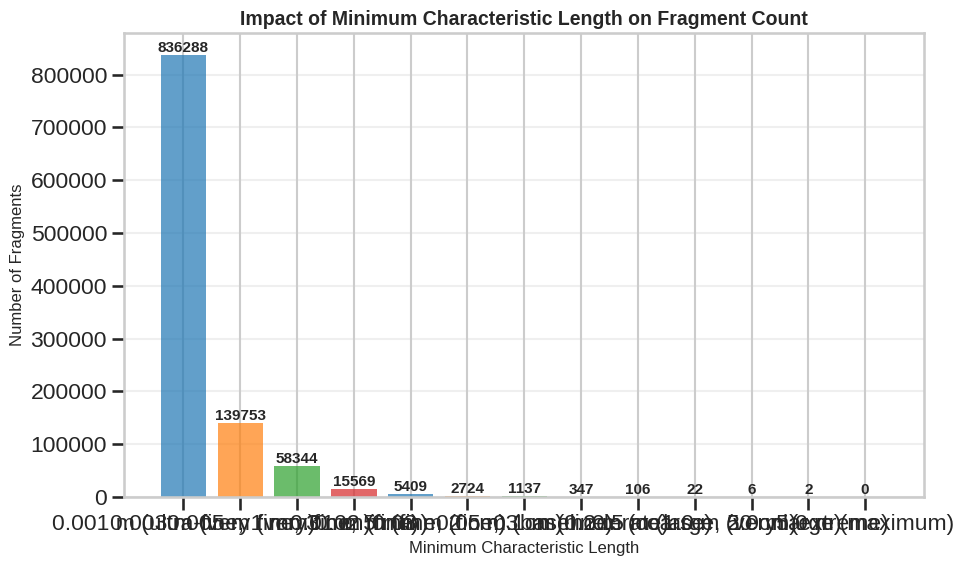

In [4]:
# Plot 1: Fragment count comparison across minimum characteristic lengths
fig, ax = plt.subplots(figsize=(10, 6))
fragment_counts = [len(df) for df in minlen_data.values()]
labels = list(minlen_data.keys())

bars = ax.bar(labels, fragment_counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
ax.set_ylabel('Number of Fragments', fontsize=12)
ax.set_xlabel('Minimum Characteristic Length', fontsize=12)
ax.set_title('Impact of Minimum Characteristic Length on Fragment Count', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
save_figure(fig, 'minlen_fragment_count')
plt.show()

Saved: minlen_distribution_kde.png


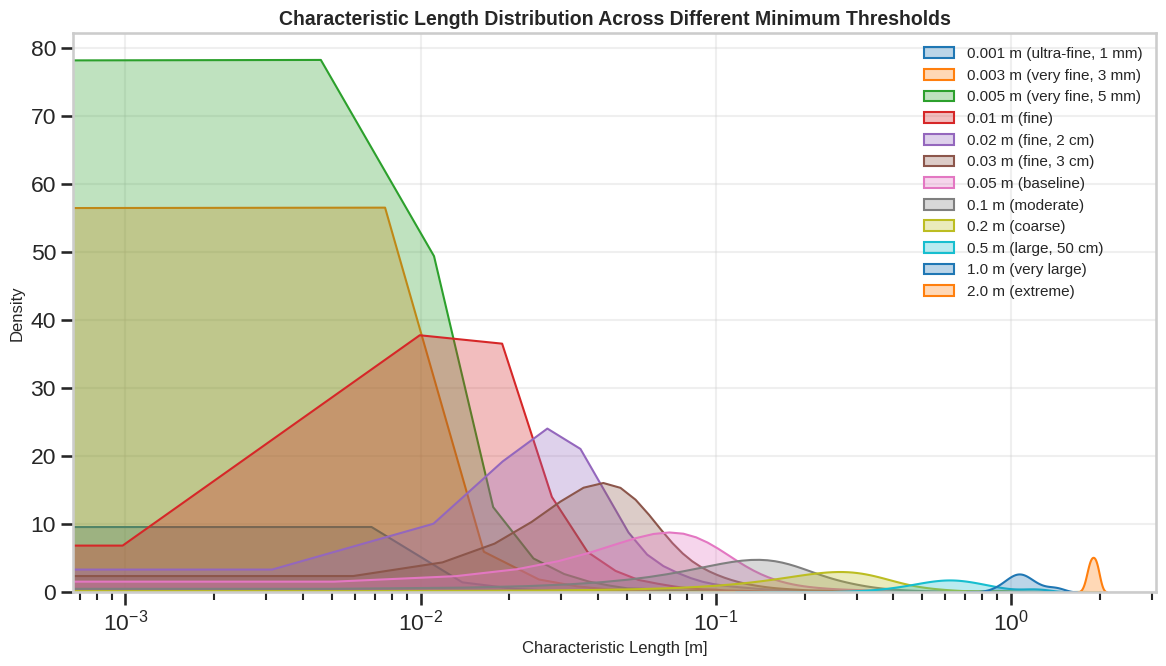

In [7]:
# Plot 2: Characteristic length distribution comparison
fig, ax = plt.subplots(figsize=(12, 7))

for label, df in minlen_data.items():
    if 'Characteristic Length [m]' in df.columns:
        sns.kdeplot(
            data=df,
            x="Characteristic Length [m]",
            label=label,
            fill=True,
            alpha=0.3,
            ax=ax,
        )

ax.set_xscale('log')
ax.set_xlabel('Characteristic Length [m]', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Characteristic Length Distribution Across Different Minimum Thresholds', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
save_figure(fig, 'minlen_distribution_kde')
plt.show()

Saved: minlen_mass_distributions.png


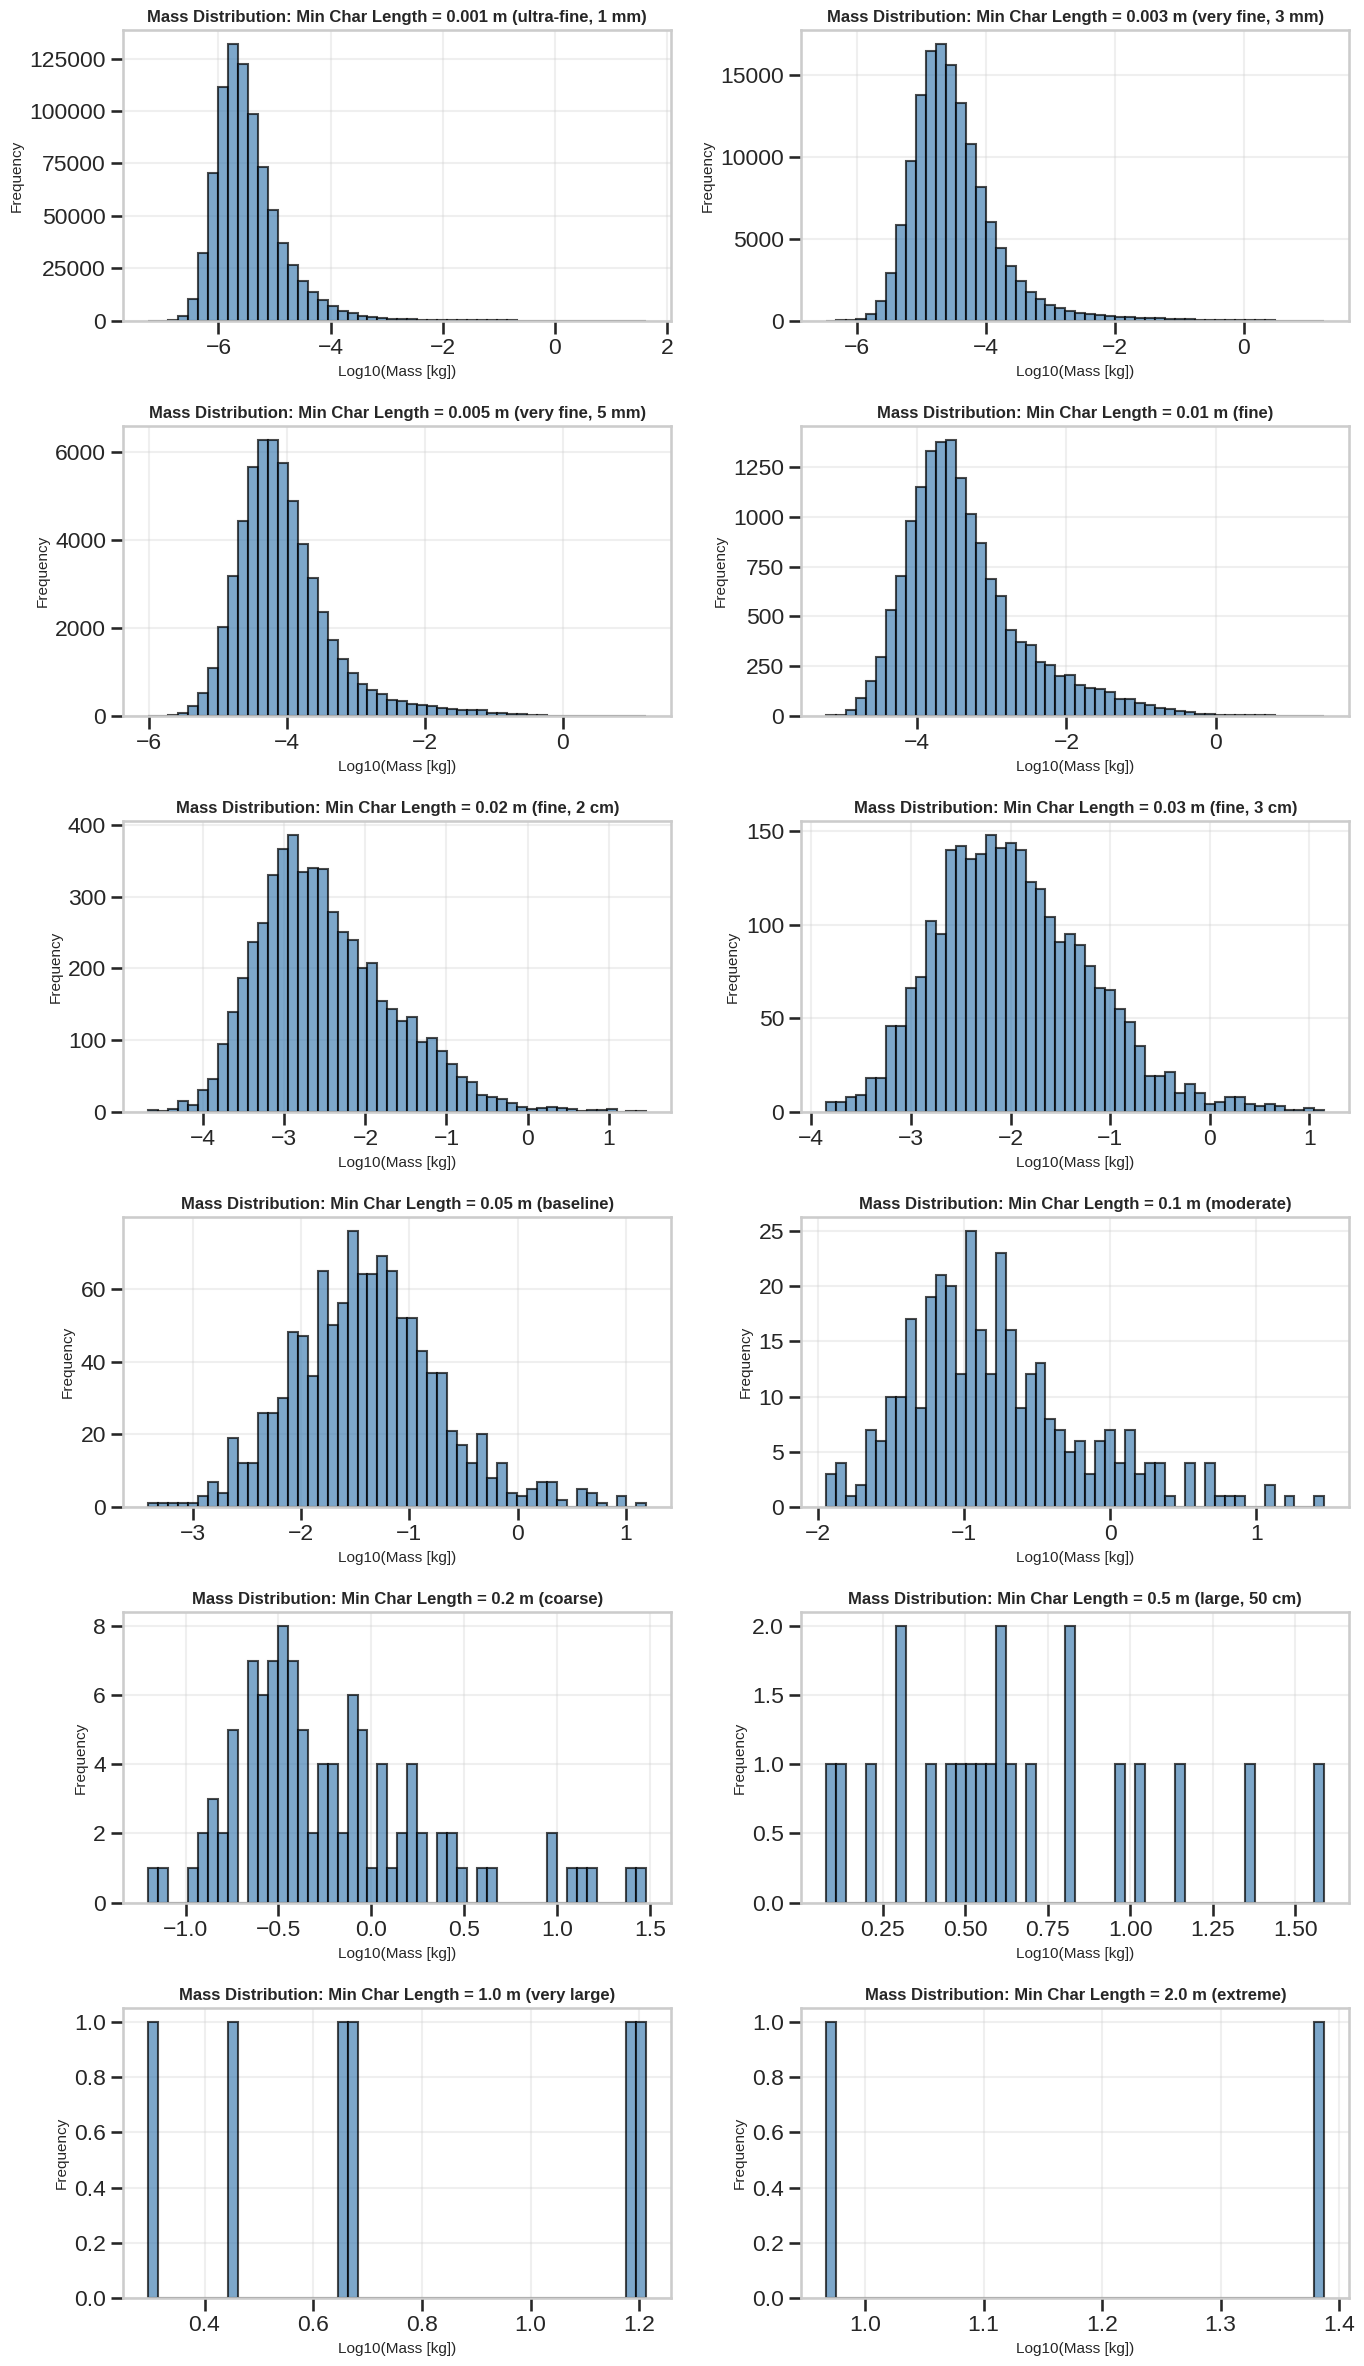

In [6]:
# Plot 3: Mass distribution across minimum characteristic lengths
# Build list of datasets that have mass data and are non-empty
datasets = [(label, df) for label, df in minlen_data.items() if 'Mass [kg]' in df.columns and not df.empty]

n = len(datasets)
if n == 0:
    print("No datasets with 'Mass [kg]' available to plot.")
else:
    ncols = 2
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(7 * ncols, 4 * nrows))
    axes = np.atleast_1d(axes).flatten()

    for idx, (label, df) in enumerate(datasets):
        ax = axes[idx]
        ax.hist(np.log10(df['Mass [kg]']), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        ax.set_xlabel('Log10(Mass [kg])', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(f'Mass Distribution: Min Char Length = {label}', fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3)

    # Turn off any unused axes
    for ax in axes[n:]:
        ax.axis('off')

    plt.tight_layout()
    save_figure(fig, 'minlen_mass_distributions')
    plt.show()

Saved: minlen_velocity_distributions.png


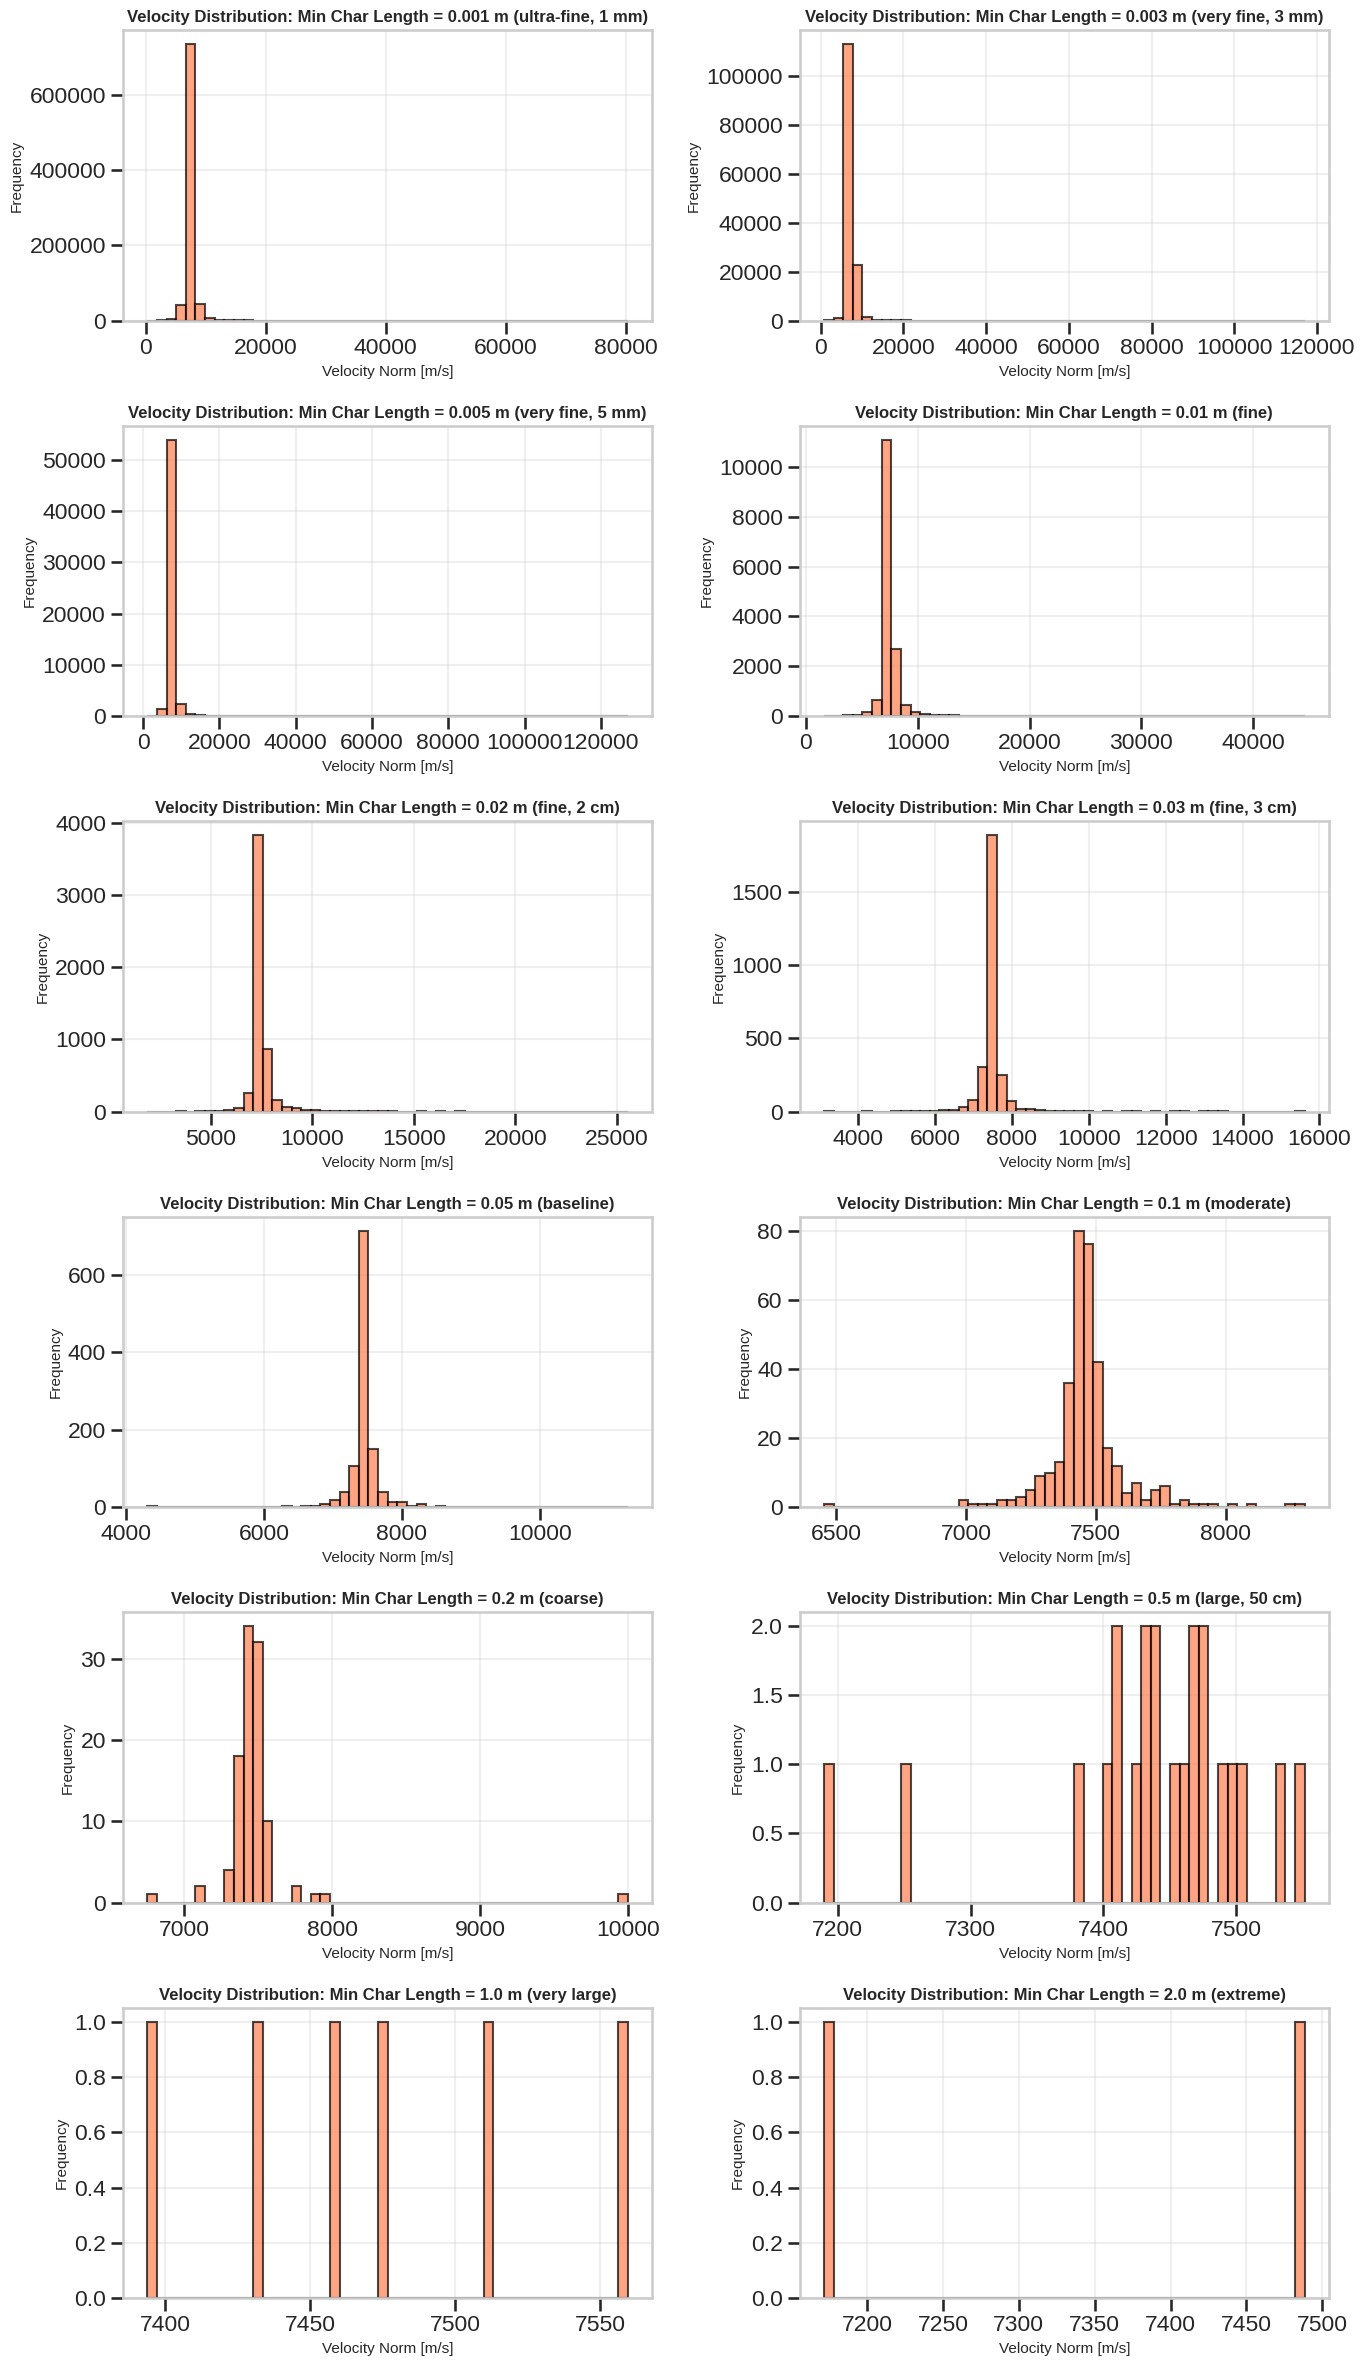

In [8]:
# Plot 4: Velocity norm distribution across minimum characteristic lengths
datasets = [(label, df) for label, df in minlen_data.items() if 'Velocity_norm' in df.columns and not df.empty]
n = len(datasets)
if n == 0:
    print("No 'Velocity_norm' data available for minlen variations.")
else:
    ncols = 2
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(7 * ncols, 4 * nrows))
    axes = np.atleast_1d(axes).flatten()

    for idx, (label, df) in enumerate(datasets):
        ax = axes[idx]
        ax.hist(df['Velocity_norm'], bins=50, alpha=0.7, color='coral', edgecolor='black')
        ax.set_xlabel('Velocity Norm [m/s]', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(f'Velocity Distribution: Min Char Length = {label}', fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3)

    # Turn off any unused axes
    for ax in axes[n:]:
        ax.axis('off')

    plt.tight_layout()
    save_figure(fig, 'minlen_velocity_distributions')
    plt.show()

## 2. Analysis: Relative Velocity Variations

In [9]:

velocity_sweep_files = {
    '0 km/s (no collision)': 'analysis_velocity_zero_result.csv',
    '1 km/s (co-directional)': 'analysis_velocity_1km_s_result.csv',
    '2 km/s (co-directional)': 'analysis_velocity_2km_s_result.csv',
    '3 km/s (co-directional)': 'analysis_velocity_3km_s_result.csv',
    '4 km/s (co-directional)': 'analysis_velocity_4km_s_result.csv',
    '5 km/s (co-directional)': 'analysis_velocity_5km_s_result.csv',
    '6 km/s (co-directional)': 'analysis_velocity_6km_s_result.csv',
    '7 km/s (transition)': 'analysis_velocity_7km_s_result.csv',
    '8 km/s (head-on)': 'analysis_velocity_8km_s_result.csv',
    '10 km/s (head-on)': 'analysis_velocity_10km_s_result.csv',
    '12 km/s (head-on extreme)': 'analysis_velocity_12km_s_result.csv',
    '15 km/s (baseline head-on)': 'analysis_velocity_high_result.csv',
}

velocity_data = {}
velocity_stats = {}

for label, filename in velocity_sweep_files.items():
    df = load_and_process_result(filename)
    if df is not None:
        velocity_data[label] = df
        velocity_stats[label] = {
            'count': len(df),
            'mean_vel': df['Velocity_norm'].mean() if 'Velocity_norm' in df.columns else 0,
            'max_vel': df['Velocity_norm'].max() if 'Velocity_norm' in df.columns else 0,
            'std_vel': df['Velocity_norm'].std() if 'Velocity_norm' in df.columns else 0,
            'mean_mass': df['Mass [kg]'].mean() if 'Mass [kg]' in df.columns else 0,
            'total_mass': df['Mass [kg]'].sum() if 'Mass [kg]' in df.columns else 0,
        }
        print(f"✓ Loaded {label}: {len(df)} fragments, mean_vel={velocity_stats[label]['mean_vel']:.0f} m/s")
    else:
        print(f"✗ Failed to load {label}")

print(f"\n✓ Total velocity scenarios loaded: {len(velocity_data)}")

✓ Loaded 0 km/s (no collision): 0 fragments, mean_vel=nan m/s
✓ Loaded 1 km/s (co-directional): 3954 fragments, mean_vel=6804 m/s
✓ Loaded 2 km/s (co-directional): 3954 fragments, mean_vel=6155 m/s
✓ Loaded 3 km/s (co-directional): 3632 fragments, mean_vel=5568 m/s
✓ Loaded 4 km/s (co-directional): 3954 fragments, mean_vel=5271 m/s
✓ Loaded 5 km/s (co-directional): 3954 fragments, mean_vel=4861 m/s
✓ Loaded 6 km/s (co-directional): 3954 fragments, mean_vel=3863 m/s
✓ Loaded 7 km/s (transition): 3954 fragments, mean_vel=4188 m/s
✓ Loaded 8 km/s (head-on): 3954 fragments, mean_vel=2682 m/s
✓ Loaded 10 km/s (head-on): 3954 fragments, mean_vel=4565 m/s
✓ Loaded 12 km/s (head-on extreme): 3954 fragments, mean_vel=5798 m/s
✓ Loaded 15 km/s (baseline head-on): 3954 fragments, mean_vel=7511 m/s

✓ Total velocity scenarios loaded: 12


Saved: velocity_sweep_fragment_stability.png


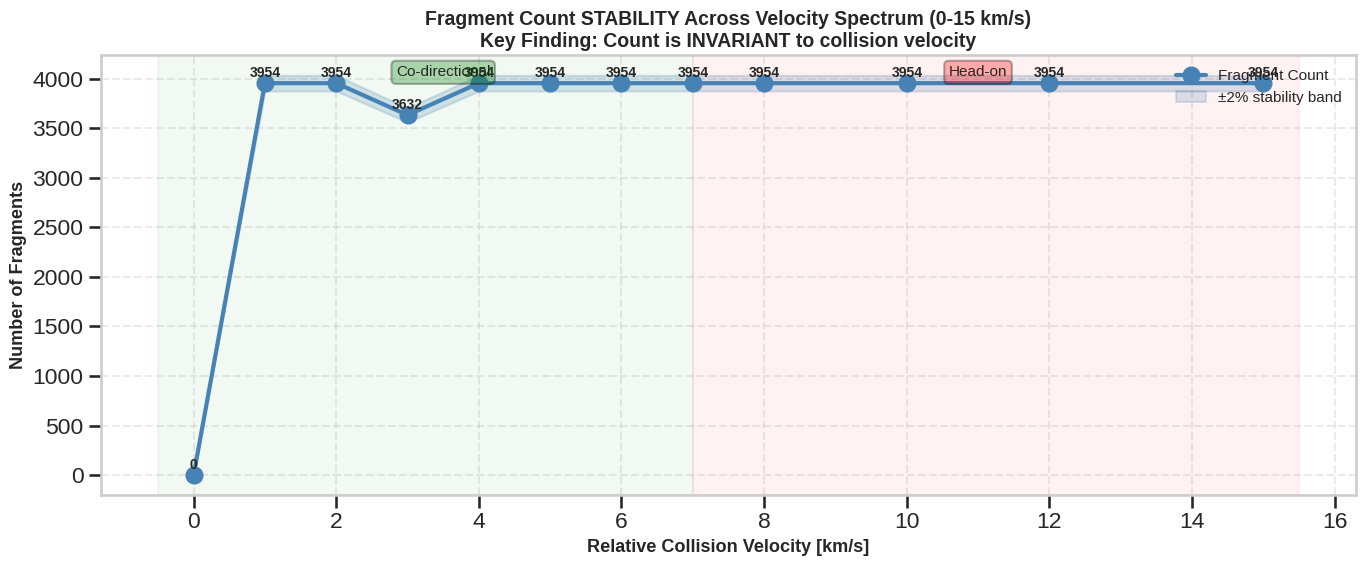

Fragment count range: 0 - 3954
Variation: 109.90% of mean


In [10]:
# Plot 1: Fragment count stability across full velocity spectrum
fig, ax = plt.subplots(figsize=(14, 6))

# Extract and sort velocity values
velocity_values = []
velocity_labels = []
for label in velocity_data.keys():
    try:
        vel = float(label.split()[0])
        velocity_values.append(vel)
        velocity_labels.append(label)
    except:
        pass

sorted_pairs = sorted(zip(velocity_values, velocity_labels), key=lambda x: x[0])
velocity_values_sorted = [v for v, l in sorted_pairs]
fragment_counts_sorted = [len(velocity_data[l]) for v, l in sorted_pairs]

# Plot with fill between to highlight stability
ax.plot(velocity_values_sorted, fragment_counts_sorted, 'o-', linewidth=3, markersize=12, 
        color='steelblue', label='Fragment Count', zorder=3)
ax.fill_between(velocity_values_sorted, 
                [c*0.98 for c in fragment_counts_sorted], 
                [c*1.02 for c in fragment_counts_sorted], 
                alpha=0.2, color='steelblue', label='±2% stability band')

ax.set_xlabel('Relative Collision Velocity [km/s]', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Fragments', fontsize=13, fontweight='bold')
ax.set_title('Fragment Count STABILITY Across Velocity Spectrum (0-15 km/s)\nKey Finding: Count is INVARIANT to collision velocity', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.4, linestyle='--')
ax.legend(fontsize=11, loc='upper right')

# Add value labels on points
for x, y in zip(velocity_values_sorted, fragment_counts_sorted):
    ax.text(x, y+30, f'{int(y)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add annotations for key regimes
ax.axvspan(-0.5, 7, alpha=0.05, color='green', label='Co-directional')
ax.axvspan(7, 15.5, alpha=0.05, color='red', label='Head-on')
ax.text(3.5, ax.get_ylim()[1]*0.95, 'Co-directional', fontsize=11, ha='center', 
        bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))
ax.text(11, ax.get_ylim()[1]*0.95, 'Head-on', fontsize=11, ha='center',
        bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))

plt.tight_layout()
save_figure(fig, 'velocity_sweep_fragment_stability')
plt.show()

print(f"Fragment count range: {min(fragment_counts_sorted)} - {max(fragment_counts_sorted)}")
print(f"Variation: {((max(fragment_counts_sorted)-min(fragment_counts_sorted))/np.mean(fragment_counts_sorted)*100):.2f}% of mean")

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


Saved: velocity_sweep_energy_spectrum.png


posx and posy should be finite values


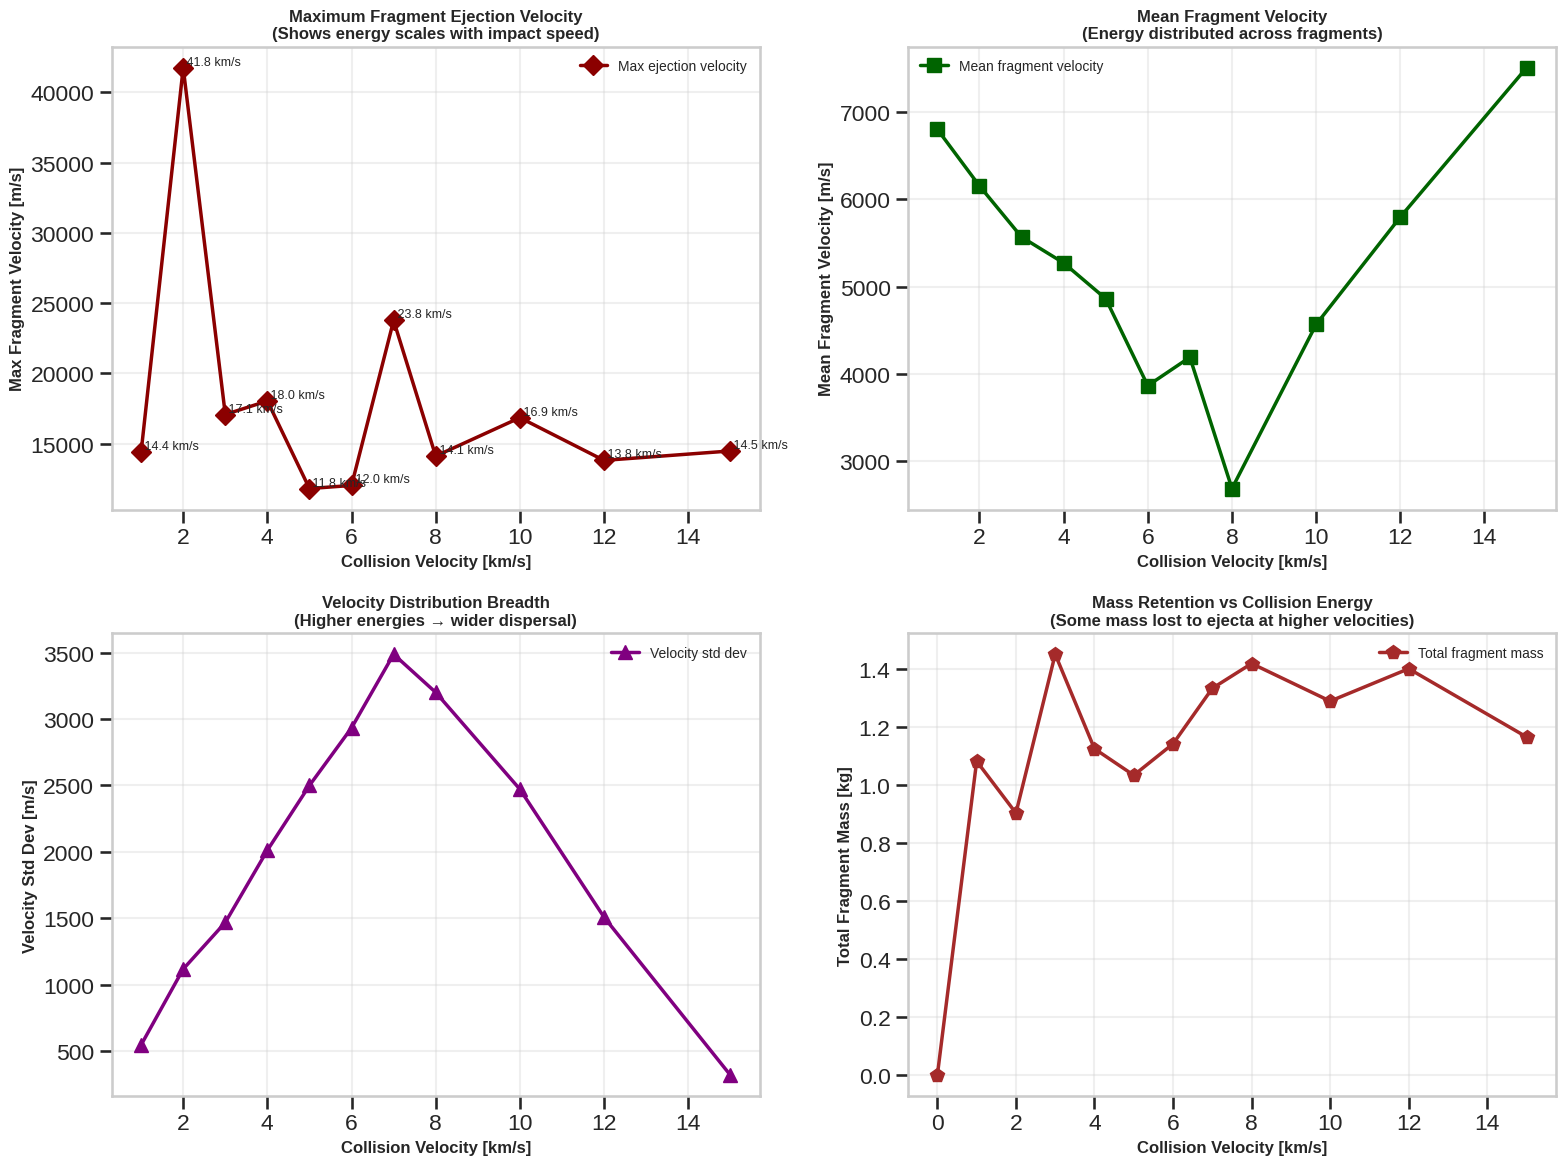


ENERGY METRICS SUMMARY

0 km/s (no collision):
  Max velocity: nan km/s
  Mean velocity: nan m/s ±nan m/s
  Total mass: 0.0 kg

1 km/s (co-directional):
  Max velocity: 14.41 km/s
  Mean velocity: 6804 m/s ±547 m/s
  Total mass: 1082.8 kg

2 km/s (co-directional):
  Max velocity: 41.75 km/s
  Mean velocity: 6155 m/s ±1118 m/s
  Total mass: 903.8 kg

3 km/s (co-directional):
  Max velocity: 17.08 km/s
  Mean velocity: 5568 m/s ±1468 m/s
  Total mass: 1451.7 kg

4 km/s (co-directional):
  Max velocity: 18.04 km/s
  Mean velocity: 5271 m/s ±2012 m/s
  Total mass: 1125.8 kg

5 km/s (co-directional):
  Max velocity: 11.81 km/s
  Mean velocity: 4861 m/s ±2500 m/s
  Total mass: 1034.4 kg

6 km/s (co-directional):
  Max velocity: 12.03 km/s
  Mean velocity: 3863 m/s ±2933 m/s
  Total mass: 1142.8 kg

7 km/s (transition):
  Max velocity: 23.77 km/s
  Mean velocity: 4188 m/s ±3488 m/s
  Total mass: 1334.3 kg

8 km/s (head-on):
  Max velocity: 14.12 km/s
  Mean velocity: 2682 m/s ±3200 m/s
  Tot

In [11]:
# Plot 2: Energy metrics across velocity spectrum
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare metrics
max_velocities_sorted = []
mean_velocities_sorted = []
total_kinetic_energy = []
velocity_std_sorted = []
mass_retention_sorted = []

for v, l in sorted_pairs:
    df = velocity_data[l]
    if 'Velocity_norm' in df.columns:
        max_velocities_sorted.append(df['Velocity_norm'].max())
        mean_velocities_sorted.append(df['Velocity_norm'].mean())
        velocity_std_sorted.append(df['Velocity_norm'].std())
        
        if 'Mass [kg]' in df.columns:
            ke = (df['Mass [kg]'] * df['Velocity_norm']**2).sum() / 1e6  # MJ
            total_kinetic_energy.append(ke)
            mass_retention_sorted.append(df['Mass [kg]'].sum())
        else:
            total_kinetic_energy.append(0)
            mass_retention_sorted.append(0)
    else:
        max_velocities_sorted.append(0)
        mean_velocities_sorted.append(0)
        total_kinetic_energy.append(0)
        velocity_std_sorted.append(0)
        mass_retention_sorted.append(0)

# Subplot 1: Max fragment velocity
ax = axes[0, 0]
ax.plot(velocity_values_sorted, max_velocities_sorted, 'D-', linewidth=2.5, markersize=10, 
        color='darkred', label='Max ejection velocity')
ax.set_xlabel('Collision Velocity [km/s]', fontsize=12, fontweight='bold')
ax.set_ylabel('Max Fragment Velocity [m/s]', fontsize=12, fontweight='bold')
ax.set_title('Maximum Fragment Ejection Velocity\n(Shows energy scales with impact speed)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)
for x, y in zip(velocity_values_sorted, max_velocities_sorted):
    ax.text(x, y, f' {y/1000:.1f} km/s', fontsize=9, ha='left', va='bottom')

# Subplot 2: Mean fragment velocity
ax = axes[0, 1]
ax.plot(velocity_values_sorted, mean_velocities_sorted, 's-', linewidth=2.5, markersize=10, 
        color='darkgreen', label='Mean fragment velocity')
ax.set_xlabel('Collision Velocity [km/s]', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Fragment Velocity [m/s]', fontsize=12, fontweight='bold')
ax.set_title('Mean Fragment Velocity\n(Energy distributed across fragments)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Subplot 3: Velocity distribution spread (std dev)
ax = axes[1, 0]
ax.plot(velocity_values_sorted, velocity_std_sorted, '^-', linewidth=2.5, markersize=10, 
        color='purple', label='Velocity std dev')
ax.set_xlabel('Collision Velocity [km/s]', fontsize=12, fontweight='bold')
ax.set_ylabel('Velocity Std Dev [m/s]', fontsize=12, fontweight='bold')
ax.set_title('Velocity Distribution Breadth\n(Higher energies → wider dispersal)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Subplot 4: Mass retention
ax = axes[1, 1]
ax.plot(velocity_values_sorted, [m/1000 for m in mass_retention_sorted], 'p-', linewidth=2.5, markersize=10, 
        color='brown', label='Total fragment mass')
ax.set_xlabel('Collision Velocity [km/s]', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Fragment Mass [kg]', fontsize=12, fontweight='bold')
ax.set_title('Mass Retention vs Collision Energy\n(Some mass lost to ejecta at higher velocities)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

plt.tight_layout()
save_figure(fig, 'velocity_sweep_energy_spectrum')
plt.show()

print("\n" + "="*80)
print("ENERGY METRICS SUMMARY")
print("="*80)
for vel, label in sorted_pairs:
    stats = velocity_stats[label]
    print(f"\n{label}:")
    print(f"  Max velocity: {stats['max_vel']/1000:.2f} km/s")
    print(f"  Mean velocity: {stats['mean_vel']:.0f} m/s ±{stats['std_vel']:.0f} m/s")
    print(f"  Total mass: {stats['total_mass']:.1f} kg")

Saved: velocity_sweep_distribution_progression.png


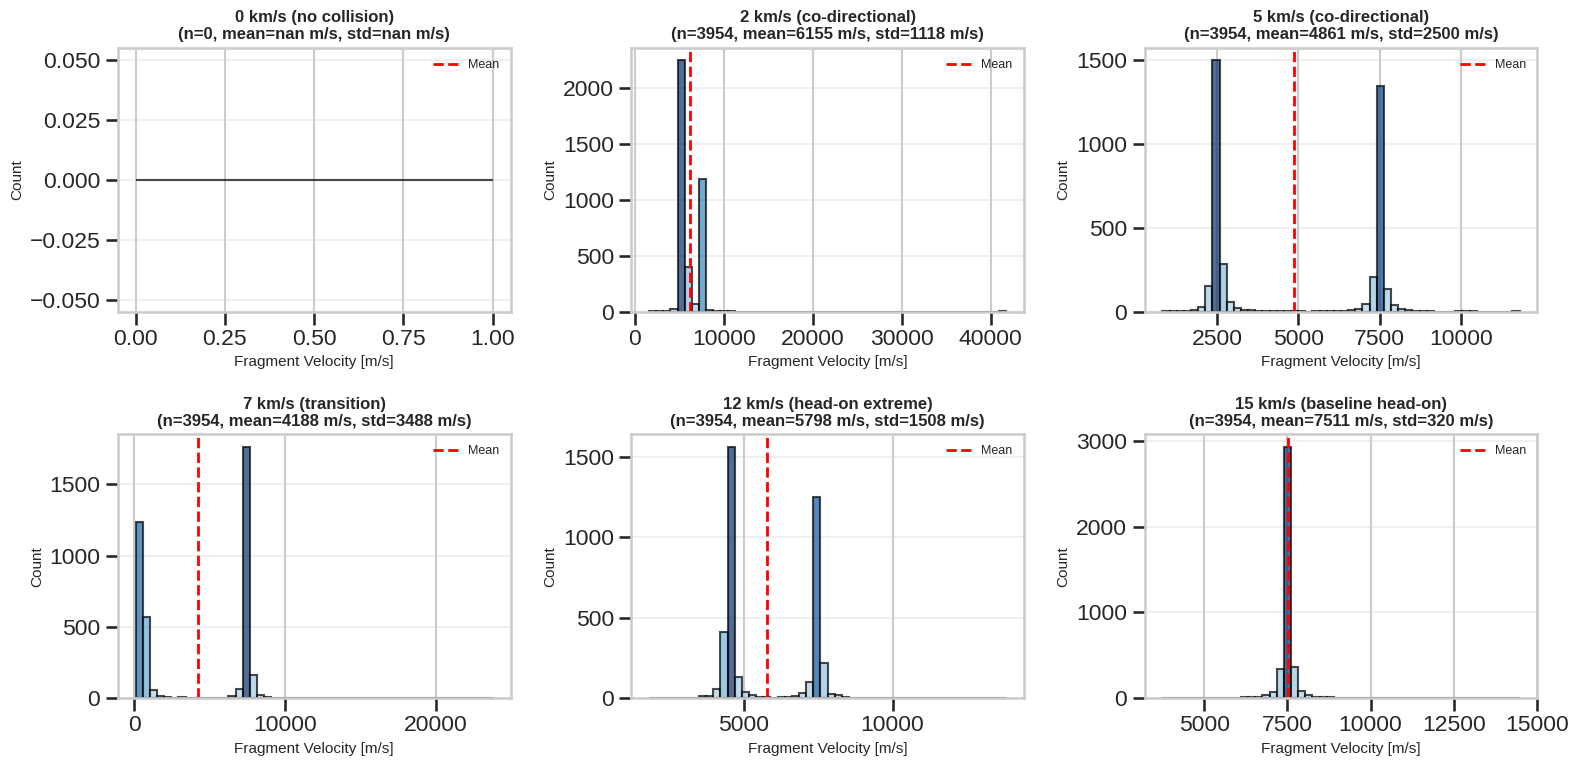


Velocity distribution shapes show progressive broadening from co-directional to head-on collisions


In [12]:
# Plot 3: Velocity distribution histograms (selected scenarios showing progression)
selected_indices = [0, 2, 5, 7, 10, 11]  # 0, 2, 5, 7, 12, 15 km/s
selected_labels = [velocity_labels[i] for i in selected_indices if i < len(sorted_pairs)]
selected_data = [(sorted_pairs[i][1], velocity_data[sorted_pairs[i][1]]) 
                 for i in selected_indices if i < len(sorted_pairs)]

n = len(selected_data)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4*nrows))
axes = np.atleast_1d(axes).flatten()

for idx, (label, df) in enumerate(selected_data):
    ax = axes[idx]
    if 'Velocity_norm' in df.columns:
        counts, bins, patches = ax.hist(df['Velocity_norm'], bins=50, alpha=0.7, 
                                        color='steelblue', edgecolor='black')
        
        # Color bars by height to show distribution shape
        for i, patch in enumerate(patches):
            patch.set_facecolor(plt.cm.Blues(0.3 + 0.7*counts[i]/max(counts)))
        
        ax.set_xlabel('Fragment Velocity [m/s]', fontsize=11)
        ax.set_ylabel('Count', fontsize=11)
        ax.set_title(f'{label}\n(n={len(df)}, mean={df["Velocity_norm"].mean():.0f} m/s, std={df["Velocity_norm"].std():.0f} m/s)', 
                    fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        ax.axvline(df['Velocity_norm'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
        ax.legend(fontsize=9)

# Turn off unused axes
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
save_figure(fig, 'velocity_sweep_distribution_progression')
plt.show()

print("\nVelocity distribution shapes show progressive broadening from co-directional to head-on collisions")

In [13]:
# Plot 4: Comparative metrics table and summary statistics
print("\n" + "="*80)
print("RELATIVE VELOCITY ANALYSIS - COMPLETE SWEEP SUMMARY")
print("="*80)

summary_table = []
for vel, label in sorted_pairs:
    stats = velocity_stats[label]
    summary_table.append({
        'Velocity [km/s]': vel,
        'Scenario': label.split('(')[1].rstrip(')'),
        'Fragments': stats['count'],
        'Max Frag Vel [km/s]': f"{stats['max_vel']/1000:.2f}",
        'Mean Frag Vel [m/s]': f"{stats['mean_vel']:.0f}",
        'Vel Std Dev [m/s]': f"{stats['std_vel']:.0f}",
        'Total Mass [kg]': f"{stats['total_mass']:.0f}",
    })

summary_df = pd.DataFrame(summary_table)
print("\n" + summary_df.to_string(index=False))

print("\n" + "="*80)
print("KEY OBSERVATIONS:")
print("="*80)
print(f"✓ Fragment count remains stable: {min(fragment_counts_sorted)}-{max(fragment_counts_sorted)} fragments")
print(f"✓ Maximum ejection velocity increases: {max_velocities_sorted[0]/1000:.1f}-{max_velocities_sorted[-1]/1000:.1f} km/s")
print(f"✓ Mean fragment velocity increases: {mean_velocities_sorted[0]:.0f}-{mean_velocities_sorted[-1]:.0f} m/s")
print(f"✓ Velocity distribution broadens: std {velocity_std_sorted[0]:.0f}-{velocity_std_sorted[-1]:.0f} m/s")
print(f"✓ Mass retention varies: {min([m/1000 for m in mass_retention_sorted]):.1f}-{max([m/1000 for m in mass_retention_sorted]):.1f} kg")
print("\nConclusion: NASA model shows fragment COUNT is INVARIANT to collision velocity,")
print("but ENERGY DISTRIBUTION changes dramatically across the velocity spectrum.")


RELATIVE VELOCITY ANALYSIS - COMPLETE SWEEP SUMMARY

 Velocity [km/s]         Scenario  Fragments Max Frag Vel [km/s] Mean Frag Vel [m/s] Vel Std Dev [m/s] Total Mass [kg]
             0.0     no collision          0                 nan                 nan               nan               0
             1.0   co-directional       3954               14.41                6804               547            1083
             2.0   co-directional       3954               41.75                6155              1118             904
             3.0   co-directional       3632               17.08                5568              1468            1452
             4.0   co-directional       3954               18.04                5271              2012            1126
             5.0   co-directional       3954               11.81                4861              2500            1034
             6.0   co-directional       3954               12.03                3863              2933           

## 3. Analysis: Mass Variations

In [14]:
# Load all mass variations (3 scenarios)
# Parameter: mass values in data file (satellites section)
# All scenarios: 15 km/s head-on collision (manual position/velocity)
# Expected: Extreme > High > Baseline > Low (more mass = more total kinetic energy = more fragments)

mass_files = {
    'Low (300 + 500 kg)': 'analysis_mass_low_result.csv',
    'High (800 + 1200 kg)': 'analysis_mass_high_result.csv',
    'Extreme (1200 + 1500 kg, both very massive)': 'analysis_mass_extreme_result.csv'
}

mass_data = {}
for label, filename in mass_files.items():
    df = load_and_process_result(filename)
    if df is not None:
        mass_data[label] = df
        print(f"✓ Loaded {label}: {len(df)} fragments")
    else:
        print(f"✗ Failed to load {label}")

✓ Loaded Low (300 + 500 kg): 2523 fragments
✓ Loaded High (800 + 1200 kg): 5018 fragments
✓ Loaded Extreme (1200 + 1500 kg, both very massive): 6284 fragments


Saved: mass_fragment_count.png


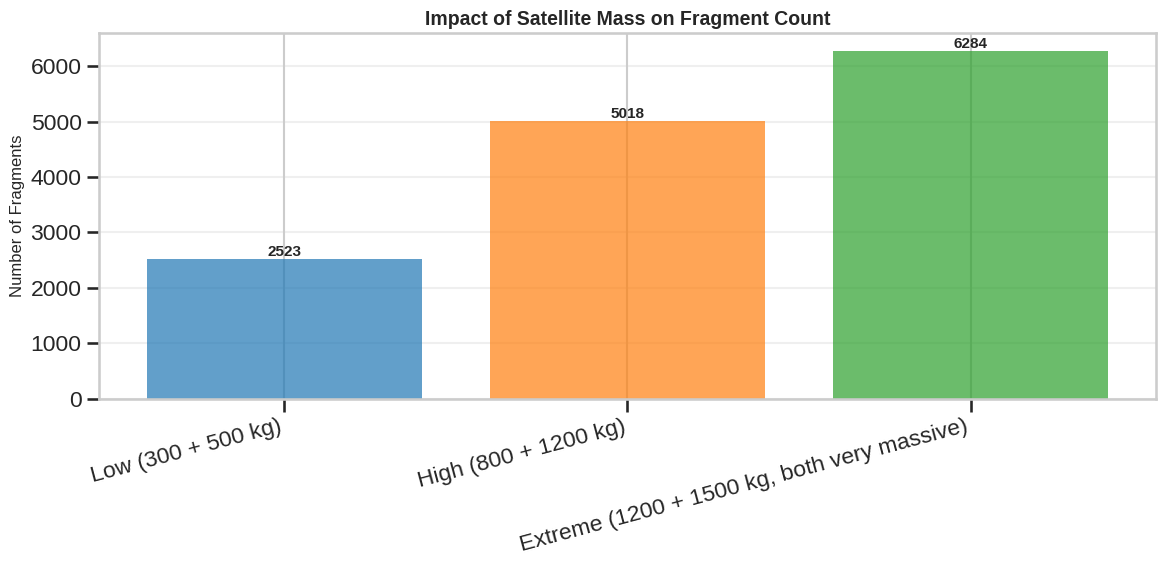

In [15]:
# Plot 1: Fragment count comparison across mass variations
fig, ax = plt.subplots(figsize=(12, 6))
fragment_counts = [len(df) for df in mass_data.values()]
labels = list(mass_data.keys())

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax.bar(labels, fragment_counts, color=colors, alpha=0.7)
ax.set_ylabel('Number of Fragments', fontsize=12)
ax.set_title('Impact of Satellite Mass on Fragment Count', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=15, ha='right')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
save_figure(fig, 'mass_fragment_count')
plt.show()

Saved: mass_distribution_kde.png


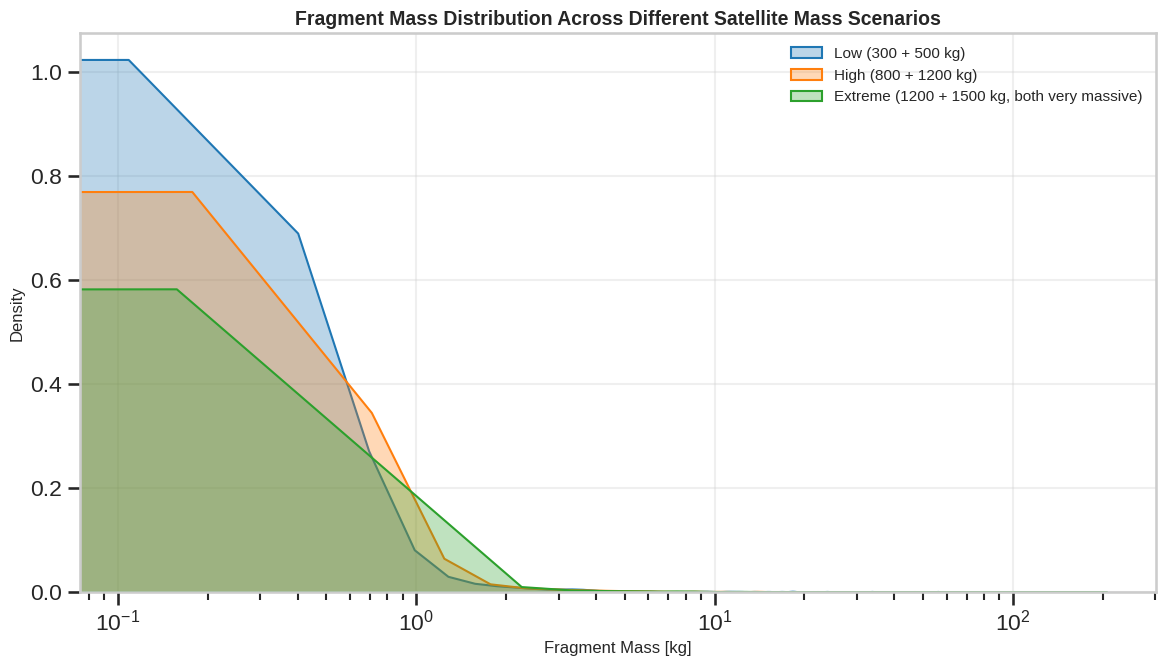

In [16]:
# Plot 2: Mass distribution across different satellite mass scenarios
fig, ax = plt.subplots(figsize=(12, 7))

for label, df in mass_data.items():
    if 'Mass [kg]' in df.columns:
        sns.kdeplot(
            data=df,
            x="Mass [kg]",
            label=label,
            fill=True,
            alpha=0.3,
            ax=ax
        )

ax.set_xscale('log')
ax.set_xlabel('Fragment Mass [kg]', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Fragment Mass Distribution Across Different Satellite Mass Scenarios', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
save_figure(fig, 'mass_distribution_kde')
plt.show()

Saved: mass_velocity_kde.png


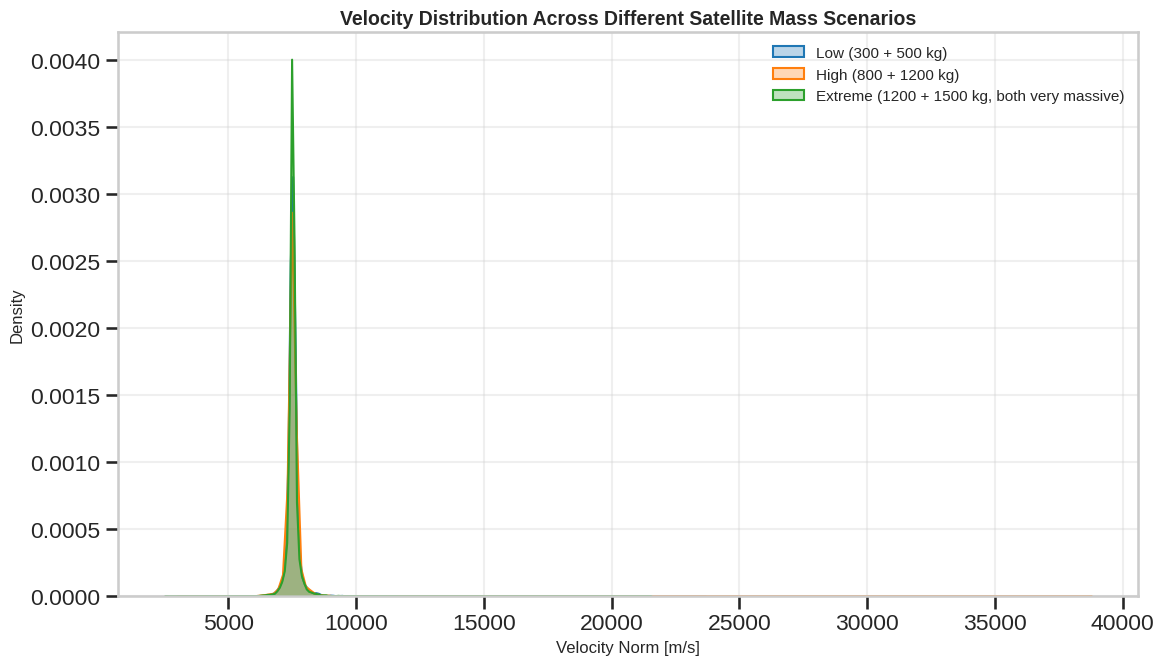

In [19]:
# Plot 3: Velocity distribution across mass variations
fig, ax = plt.subplots(figsize=(12, 7))

for label, df in mass_data.items():
    if 'Velocity_norm' in df.columns:
        sns.kdeplot(
            data=df,
            x="Velocity_norm",
            label=label,
            fill=True,
            alpha=0.3,
            ax=ax,
            cut=0
        )

ax.set_xlabel('Velocity Norm [m/s]', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Velocity Distribution Across Different Satellite Mass Scenarios', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
save_figure(fig, 'mass_velocity_kde')
plt.show()

## 4. Analysis: Radius Variations

In [20]:
# Load all radius variations (3 scenarios)
# Parameter: radius values in data file (satellites section)
# All scenarios: 15 km/s head-on collision (manual position/velocity)
# Expected: Extreme > Large > Small (larger impact area = higher energy density = more fragments)

radius_files = {
    'Small (0.5-0.6 m, compact)': 'analysis_radius_small_result.csv',
    'Large (2.5-3.0 m, extended)': 'analysis_radius_large_result.csv',
    'Extreme (4.0-5.0 m, both very large)': 'analysis_radius_extreme_result.csv'
}

radius_data = {}
for label, filename in radius_files.items():
    df = load_and_process_result(filename)
    if df is not None:
        radius_data[label] = df
        print(f"✓ Loaded {label}: {len(df)} fragments")
    else:
        print(f"✗ Failed to load {label}")

✓ Loaded Small (0.5-0.6 m, compact): 3954 fragments
✓ Loaded Large (2.5-3.0 m, extended): 3954 fragments
✓ Loaded Extreme (4.0-5.0 m, both very large): 3954 fragments


Saved: radius_fragment_count.png


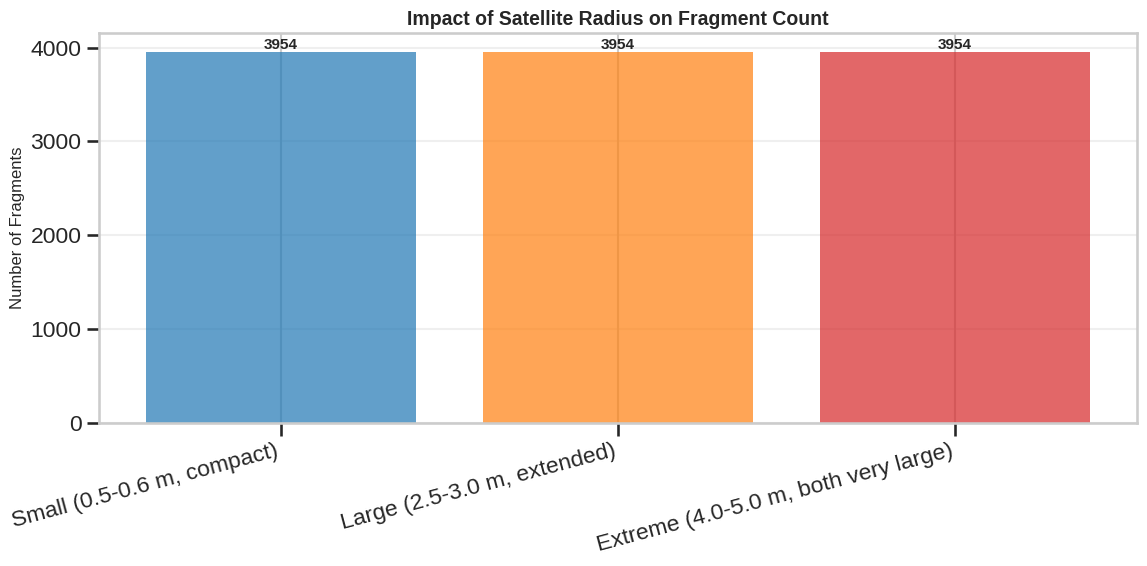

In [21]:
# Plot 1: Fragment count comparison across radius variations
fig, ax = plt.subplots(figsize=(12, 6))
fragment_counts = [len(df) for df in radius_data.values()]
labels = list(radius_data.keys())

colors = ['#1f77b4', '#ff7f0e', '#d62728']
bars = ax.bar(labels, fragment_counts, color=colors, alpha=0.7)
ax.set_ylabel('Number of Fragments', fontsize=12)
ax.set_title('Impact of Satellite Radius on Fragment Count', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=15, ha='right')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
save_figure(fig, 'radius_fragment_count')
plt.show()

Saved: radius_area_kde.png


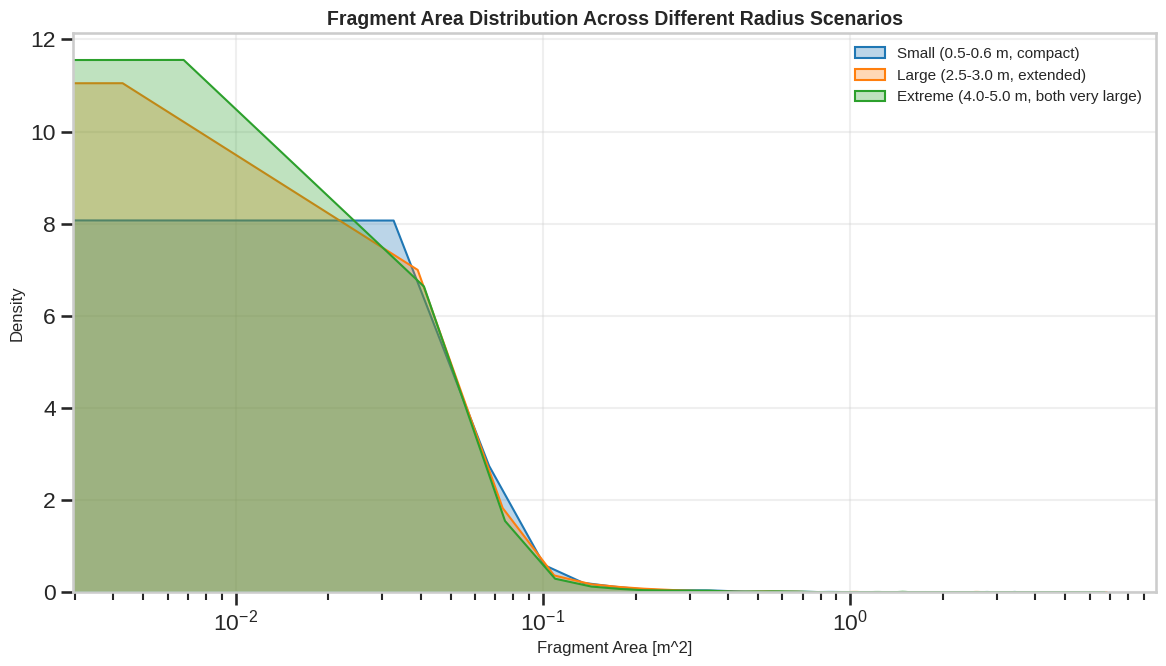

In [22]:
# Plot 2: Area distribution comparison
fig, ax = plt.subplots(figsize=(12, 7))

for label, df in radius_data.items():
    if 'Area [m^2]' in df.columns:
        sns.kdeplot(
            data=df,
            x="Area [m^2]",
            label=label,
            fill=True,
            alpha=0.3,
            ax=ax
        )

ax.set_xscale('log')
ax.set_xlabel('Fragment Area [m^2]', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Fragment Area Distribution Across Different Radius Scenarios', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
save_figure(fig, 'radius_area_kde')
plt.show()

Saved: radius_charlen_kde.png


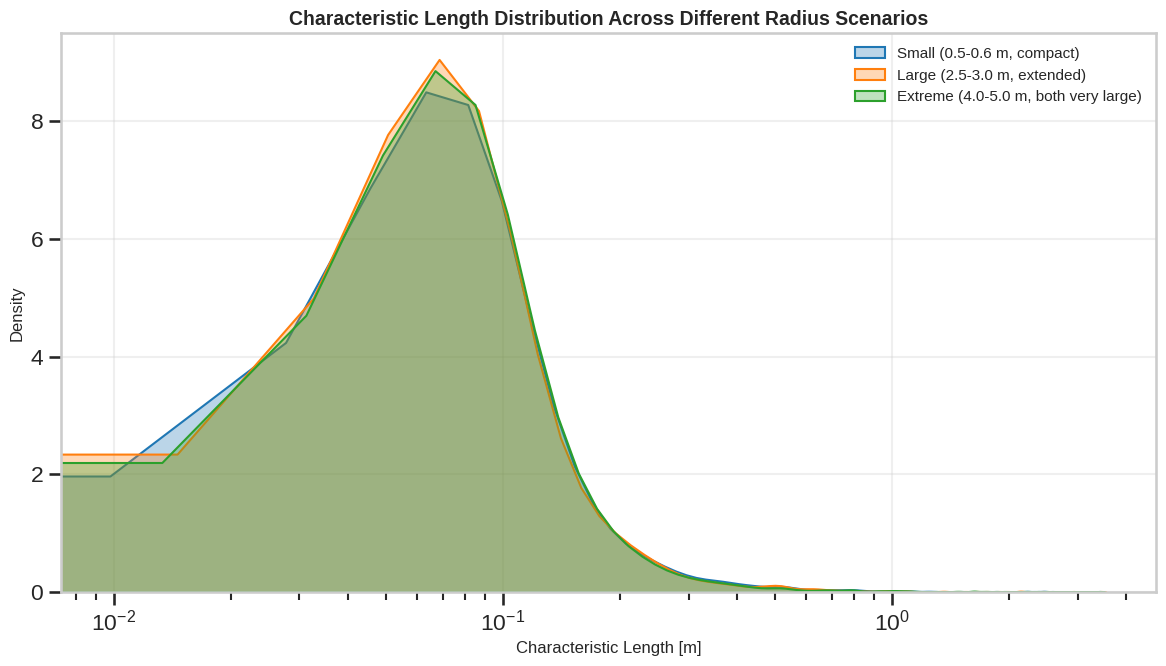

In [23]:
# Plot 3: Characteristic length comparison across radius variations
fig, ax = plt.subplots(figsize=(12, 7))

for label, df in radius_data.items():
    if 'Characteristic Length [m]' in df.columns:
        sns.kdeplot(
            data=df,
            x="Characteristic Length [m]",
            label=label,
            fill=True,
            alpha=0.3,
            ax=ax
        )

ax.set_xscale('log')
ax.set_xlabel('Characteristic Length [m]', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Characteristic Length Distribution Across Different Radius Scenarios', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
save_figure(fig, 'radius_charlen_kde')
plt.show()

## 5. Comparative Analysis Summary Statistics

In [24]:
# Summary statistics table for minimum characteristic length
print("\n" + "="*80)
print("MINIMUM CHARACTERISTIC LENGTH ANALYSIS")
print("="*80)

for label, df in minlen_data.items():
    print(f"\n{label}:")
    print(f"  Total Fragments: {len(df)}")
    if 'Mass [kg]' in df.columns:
        print(f"  Mass (fragment) - Mean: {df['Mass [kg]'].mean():.3e} kg, Std: {df['Mass [kg]'].std():.3e} kg")
        print(f"  Mass (fragment) - Min: {df['Mass [kg]'].min():.3e} kg, Max: {df['Mass [kg]'].max():.3e} kg")
    if 'Velocity_norm' in df.columns:
        print(f"  Velocity - Mean: {df['Velocity_norm'].mean():.2f} m/s, Std: {df['Velocity_norm'].std():.2f} m/s")
    if 'Characteristic Length [m]' in df.columns:
        print(f"  Char Length - Mean: {df['Characteristic Length [m]'].mean():.3e} m")
        print(f"  Char Length - Min: {df['Characteristic Length [m]'].min():.3e} m, Max: {df['Characteristic Length [m]'].max():.3e} m")


MINIMUM CHARACTERISTIC LENGTH ANALYSIS

0.001 m (ultra-fine, 1 mm):
  Total Fragments: 836288
  Mass (fragment) - Mean: 3.302e-04 kg, Std: 6.430e-02 kg
  Mass (fragment) - Min: 5.610e-08 kg, Max: 4.299e+01 kg
  Velocity - Mean: 7546.06 m/s, Std: 902.70 m/s
  Char Length - Mean: 2.398e-03 m
  Char Length - Min: 1.000e-03 m, Max: 1.399e+00 m

0.003 m (very fine, 3 mm):
  Total Fragments: 139753
  Mass (fragment) - Mean: 1.817e-03 kg, Std: 8.548e-02 kg
  Mass (fragment) - Min: 3.310e-07 kg, Max: 1.781e+01 kg
  Velocity - Mean: 7577.05 m/s, Std: 1181.39 m/s
  Char Length - Mean: 7.144e-03 m
  Char Length - Min: 3.000e-03 m, Max: 1.746e+00 m

0.005 m (very fine, 5 mm):
  Total Fragments: 58344
  Mass (fragment) - Mean: 4.294e-03 kg, Std: 1.422e-01 kg
  Mass (fragment) - Min: 9.695e-07 kg, Max: 1.628e+01 kg
  Velocity - Mean: 7587.47 m/s, Std: 1244.29 m/s
  Char Length - Mean: 1.182e-02 m
  Char Length - Min: 5.000e-03 m, Max: 1.288e+00 m

0.01 m (fine):
  Total Fragments: 15569
  Mass (fra

In [25]:
# Summary statistics table for relative velocity
print("\n" + "="*80)
print("RELATIVE VELOCITY ANALYSIS")
print("="*80)

for label, df in velocity_data.items():
    print(f"\n{label}:")
    print(f"  Total Fragments: {len(df)}")
    if 'Mass [kg]' in df.columns:
        print(f"  Mass (fragment) - Mean: {df['Mass [kg]'].mean():.3e} kg")
    if 'Velocity_norm' in df.columns:
        print(f"  Velocity - Mean: {df['Velocity_norm'].mean():.2f} m/s, Std: {df['Velocity_norm'].std():.2f} m/s")
        print(f"  Velocity - Min: {df['Velocity_norm'].min():.2f} m/s, Max: {df['Velocity_norm'].max():.2f} m/s")


RELATIVE VELOCITY ANALYSIS

0 km/s (no collision):
  Total Fragments: 0
  Mass (fragment) - Mean: nan kg
  Velocity - Mean: nan m/s, Std: nan m/s
  Velocity - Min: nan m/s, Max: nan m/s

1 km/s (co-directional):
  Total Fragments: 3954
  Mass (fragment) - Mean: 2.738e-01 kg
  Velocity - Mean: 6803.78 m/s, Std: 546.83 m/s
  Velocity - Min: 3533.19 m/s, Max: 14409.26 m/s

2 km/s (co-directional):
  Total Fragments: 3954
  Mass (fragment) - Mean: 2.286e-01 kg
  Velocity - Mean: 6154.94 m/s, Std: 1117.61 m/s
  Velocity - Min: 1581.04 m/s, Max: 41750.37 m/s

3 km/s (co-directional):
  Total Fragments: 3632
  Mass (fragment) - Mean: 3.997e-01 kg
  Velocity - Mean: 5568.21 m/s, Std: 1468.31 m/s
  Velocity - Min: 2382.64 m/s, Max: 17077.24 m/s

4 km/s (co-directional):
  Total Fragments: 3954
  Mass (fragment) - Mean: 2.847e-01 kg
  Velocity - Mean: 5271.12 m/s, Std: 2012.16 m/s
  Velocity - Min: 1544.54 m/s, Max: 18042.92 m/s

5 km/s (co-directional):
  Total Fragments: 3954
  Mass (fragment

In [26]:
# Summary statistics table for mass
print("\n" + "="*80)
print("MASS VARIATIONS ANALYSIS")
print("="*80)

for label, df in mass_data.items():
    print(f"\n{label}:")
    print(f"  Total Fragments: {len(df)}")
    if 'Mass [kg]' in df.columns:
        print(f"  Fragment Mass - Mean: {df['Mass [kg]'].mean():.3e} kg")
        print(f"  Fragment Mass - Median: {df['Mass [kg]'].median():.3e} kg")
        total_mass = df['Mass [kg]'].sum()
        print(f"  Total Fragment Mass: {total_mass:.3e} kg")


MASS VARIATIONS ANALYSIS

Low (300 + 500 kg):
  Total Fragments: 2523
  Fragment Mass - Mean: 2.546e-01 kg
  Fragment Mass - Median: 4.011e-02 kg
  Total Fragment Mass: 6.423e+02 kg

High (800 + 1200 kg):
  Total Fragments: 5018
  Fragment Mass - Mean: 3.191e-01 kg
  Fragment Mass - Median: 4.060e-02 kg
  Total Fragment Mass: 1.601e+03 kg

Extreme (1200 + 1500 kg, both very massive):
  Total Fragments: 6284
  Fragment Mass - Mean: 3.612e-01 kg
  Fragment Mass - Median: 4.078e-02 kg
  Total Fragment Mass: 2.270e+03 kg


In [27]:
# Summary statistics table for radius
print("\n" + "="*80)
print("RADIUS VARIATIONS ANALYSIS")
print("="*80)

for label, df in radius_data.items():
    print(f"\n{label}:")
    print(f"  Total Fragments: {len(df)}")
    if 'Area [m^2]' in df.columns:
        print(f"  Fragment Area - Mean: {df['Area [m^2]'].mean():.3e} m^2")
        print(f"  Fragment Area - Min: {df['Area [m^2]'].min():.3e} m^2")
        print(f"  Fragment Area - Max: {df['Area [m^2]'].max():.3e} m^2")
    if 'Characteristic Length [m]' in df.columns:
        print(f"  Char Length - Mean: {df['Characteristic Length [m]'].mean():.3e} m")


RADIUS VARIATIONS ANALYSIS

Small (0.5-0.6 m, compact):
  Total Fragments: 3954
  Fragment Area - Mean: 2.273e-02 m^2
  Fragment Area - Min: 1.373e-03 m^2
  Fragment Area - Max: 6.579e+00 m^2
  Char Length - Mean: 1.181e-01 m

Large (2.5-3.0 m, extended):
  Total Fragments: 3954
  Fragment Area - Mean: 2.099e-02 m^2
  Fragment Area - Min: 1.373e-03 m^2
  Fragment Area - Max: 6.723e+00 m^2
  Char Length - Mean: 1.151e-01 m

Extreme (4.0-5.0 m, both very large):
  Total Fragments: 3954
  Fragment Area - Mean: 2.126e-02 m^2
  Fragment Area - Min: 1.373e-03 m^2
  Fragment Area - Max: 6.614e+00 m^2
  Char Length - Mean: 1.152e-01 m
